In [ ]:
#check CPU/GPU
import torch
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA是否可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU设备: {torch.cuda.get_device_name(0)}")
else:
    print("当前使用CPU")

PyTorch版本: 2.9.0+cu128
CUDA是否可用: True
GPU设备: Tesla T4


In [ ]:
!pip install --upgrade torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

print("All libraries are successfully imported!")
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

All libraries are successfully imported!
PyTorch Version: 2.9.0+cu128
Torchvision Version: 0.24.0+cu128


In [ ]:
import os
import urllib.request
import zipfile
from pathlib import Path

# Define dataset path
dataset_path = './data/tiny-imagenet-200'

# Download Tiny-ImageNet dataset if not exists
if not os.path.exists(dataset_path):
    print("Downloading Tiny-ImageNet dataset...")
    url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
    zip_path = './data/tiny-imagenet-200.zip'

    # Create data directory
    os.makedirs('./data', exist_ok=True)

    # Download with progress
    def download_progress(count, block_size, total_size):
        percent = int(count * block_size * 100 / total_size)
        print(f'\rDownloading: {percent}%', end='')

    urllib.request.urlretrieve(url, zip_path, download_progress)
    print('\nDownload completed!')

    # Extract zip file
    print('Extracting dataset...')
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('./data')
    print('Extraction completed!')

    # Remove zip file to save space
    os.remove(zip_path)
    print('Zip file removed.')
else:
    print('Tiny-ImageNet dataset already exists.')

# Check dataset structure
print(f'\nDataset structure:')
print(f'Train directory: {os.path.exists(os.path.join(dataset_path, "train"))}')
print(f'Validation directory: {os.path.exists(os.path.join(dataset_path, "val"))}')
print(f'Test directory: {os.path.exists(os.path.join(dataset_path, "test"))}')

Tiny-ImageNet dataset already exists.

Dataset structure:
Train directory: True
Validation directory: True
Test directory: True


In [ ]:
# ============================================================================
# REORGANIZE VALIDATION SET
# ============================================================================
# The validation set in Tiny-ImageNet has a different structure than training
# We need to reorganize it to match the training set structure
# Original: val/images/val_*.JPEG
# Target: val/class_name/val_*.JPEG
# ============================================================================

import shutil
from collections import defaultdict

val_dir = os.path.join(dataset_path, 'val')
val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')

# Check if validation set needs reorganization
val_img_dir = os.path.join(val_dir, 'images')
if os.path.exists(val_img_dir):
    print('Reorganizing validation set...')

    # Read validation annotations
    # Format: filename, class_id, bbox_x, bbox_y, bbox_width, bbox_height
    val_dict = {}
    with open(val_annotations_file, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            val_dict[parts[0]] = parts[1]  # filename -> class_id

    # Create class directories in validation folder
    for class_id in set(val_dict.values()):
        class_dir = os.path.join(val_dir, class_id)
        os.makedirs(class_dir, exist_ok=True)

    # Move images to corresponding class directories
    for img_name, class_id in val_dict.items():
        src = os.path.join(val_img_dir, img_name)
        dst = os.path.join(val_dir, class_id, img_name)
        if os.path.exists(src):
            shutil.move(src, dst)

    # Remove old images directory
    if os.path.exists(val_img_dir):
        os.rmdir(val_img_dir)

    print('Validation set reorganization completed!')
else:
    print('Validation set already organized.')

# Display dataset statistics
train_dir = os.path.join(dataset_path, 'train')
num_classes = len(os.listdir(train_dir))
print(f'\nDataset Statistics:')
print(f'Number of classes: {num_classes}')
print(f'Training samples: ~{num_classes * 500}')
print(f'Validation samples: ~{num_classes * 50}')

Validation set already organized.

Dataset Statistics:
Number of classes: 200
Training samples: ~100000
Validation samples: ~10000


In [ ]:
# ============================================================================
# DATA TRANSFORMATIONS AND DATALOADERS
# ============================================================================
# Define data augmentation for training and normalization for validation
# For baseline, we use basic transformations
# ============================================================================

from torchvision import datasets, transforms

# Calculate mean and std of Tiny-ImageNet (ImageNet statistics as approximation)
# Tiny-ImageNet is a subset of ImageNet, so we use ImageNet normalization
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# Training transformations (basic augmentation for baseline)
train_transform = transforms.Compose([
    transforms.RandomCrop(64, padding=8),  # Random crop with padding
    transforms.RandomHorizontalFlip(),      # Random horizontal flip
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize(mean=MEAN, std=STD)  # Normalize
])

# Validation transformations (no augmentation)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Load datasets
print('Loading datasets...')
train_dataset = datasets.ImageFolder(
    root=os.path.join(dataset_path, 'train'),
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root=os.path.join(dataset_path, 'val'),
    transform=val_transform
)

# Create data loaders
batch_size = 128  # Adjust based on your GPU memory
num_workers = 2   # Number of worker threads for data loading

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True  # Faster data transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Number of classes: {len(train_dataset.classes)}')

Loading datasets...
Training batches: 782
Validation batches: 79
Number of classes: 200


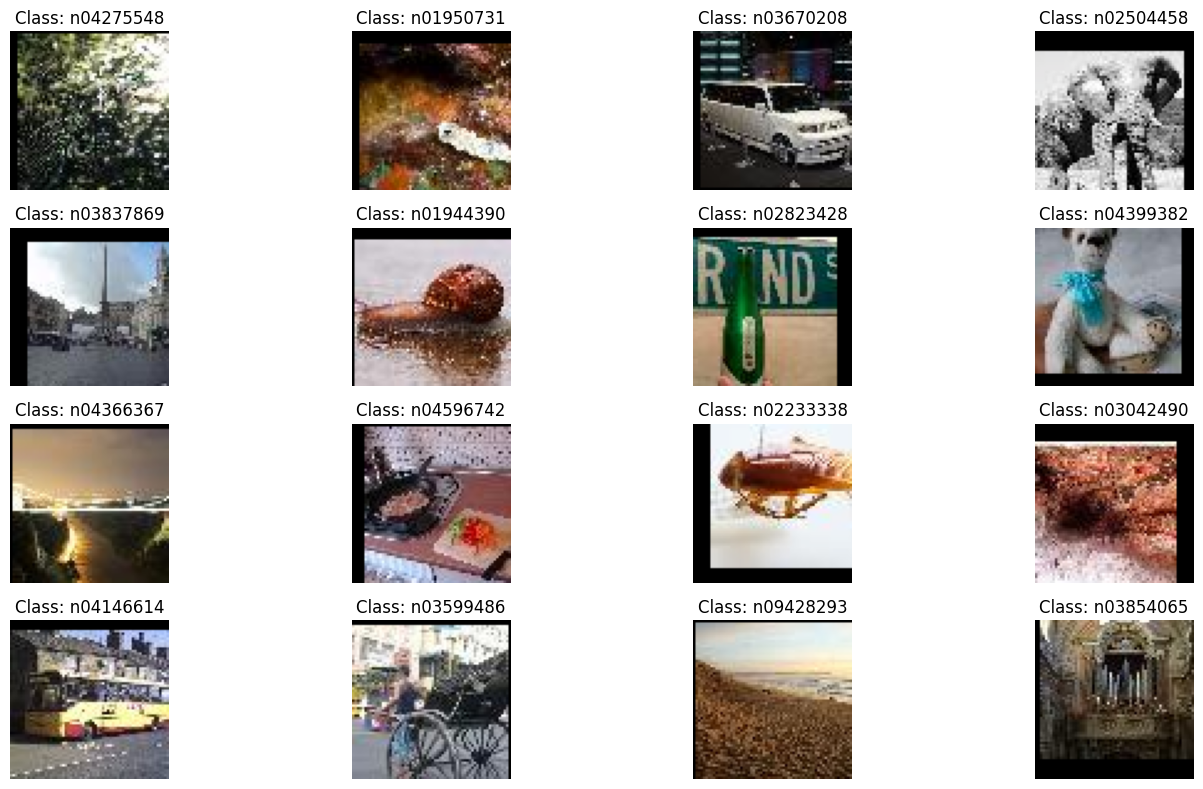

Sample batch shape: torch.Size([128, 3, 64, 64])
Sample labels: tensor([152,  17, 116,  57, 124,  15,  73, 161, 157, 174,  41,  91, 145, 111,
        198, 126])


In [ ]:
# ============================================================================
# VISUALIZE SAMPLE IMAGES
# ============================================================================
# Display some sample images from the training set to verify data loading
# ============================================================================

def imshow(img, title=None):
    """Display a tensor image"""
    img = img.numpy().transpose((1, 2, 0))
    # Denormalize
    mean = np.array(MEAN)
    std = np.array(STD)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
fig = plt.figure(figsize=(15, 8))
for idx in range(16):
    ax = fig.add_subplot(4, 4, idx+1)
    imshow(images[idx], title=f'Class: {train_dataset.classes[labels[idx]]}')
plt.tight_layout()
plt.savefig('tiny_imagenet_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Sample batch shape: {images.shape}')
print(f'Sample labels: {labels[:16]}')

In [ ]:
# ============================================================================
# BASELINE CNN MODEL FOR TINY-IMAGENET
# ============================================================================
# A simple convolutional neural network as baseline
# Architecture: 4 Conv blocks + 2 FC layers
# Each conv block: Conv2d -> BatchNorm -> ReLU -> MaxPool
# ============================================================================

class BaselineCNN(nn.Module):
    """
    Baseline CNN model for Tiny-ImageNet classification
    Input: 64x64x3 images
    Output: 200 class predictions
    """
    def __init__(self, num_classes=200):
        super(BaselineCNN, self).__init__()

        # Convolutional Block 1: 64x64x3 -> 32x32x64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional Block 2: 32x32x64 -> 16x16x128
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional Block 3: 16x16x128 -> 8x8x256
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional Block 4: 8x8x256 -> 4x4x512
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        # After 4 max pooling operations: 64 -> 32 -> 16 -> 8 -> 4
        # Feature map size: 4x4x512 = 8192
        self.fc = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        """Forward pass"""
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc(x)
        return x

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = BaselineCNN(num_classes=200).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'\nModel Architecture:')
print(model)
print(f'\nTotal parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')

Using device: cuda

Model Architecture:
BaselineCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Co

In [ ]:
# ============================================================================
# TRAINING AND VALIDATION FUNCTIONS
# ============================================================================
# Define functions for training one epoch and validating the model
# ============================================================================

def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """
    Train the model for one epoch

    Args:
        model: Neural network model
        train_loader: Training data loader
        criterion: Loss function
        optimizer: Optimizer
        device: Device to train on (cuda/cpu)
        epoch: Current epoch number

    Returns:
        avg_loss: Average training loss
        accuracy: Training accuracy
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    correct = 0
    total = 0

    # Progress tracking
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Print progress every 50 batches
        if (batch_idx + 1) % 50 == 0:
            print(f'Epoch: {epoch} | Batch: {batch_idx+1}/{len(train_loader)} | '
                  f'Loss: {running_loss/(batch_idx+1):.3f} | '
                  f'Acc: {100.*correct/total:.2f}%')

    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy


def validate(model, val_loader, criterion, device):
    """
    Validate the model on validation set

    Args:
        model: Neural network model
        val_loader: Validation data loader
        criterion: Loss function
        device: Device to validate on (cuda/cpu)

    Returns:
        avg_loss: Average validation loss
        accuracy: Validation accuracy
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    correct = 0
    total = 0

    # No gradient computation during validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy

In [ ]:
# ============================================================================
# TRAINING CONFIGURATION
# ============================================================================
# Set up loss function, optimizer, and learning rate scheduler
# ============================================================================

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer: SGD with momentum (baseline)
optimizer = optim.SGD(
    model.parameters(),
    lr=0.1,              # Initial learning rate
    momentum=0.9,        # Momentum factor
    weight_decay=5e-4    # L2 regularization
)

# Learning rate scheduler: reduce LR on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',          # Monitor validation accuracy (maximize)
    factor=0.5,          # Reduce LR by half
    patience=5,          # Wait 5 epochs before reducing
    min_lr=1e-6          # Minimum learning rate
)

# Alternative scheduler: Step decay (commented out)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Alternative scheduler: Cosine annealing (commented out)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

print('Training configuration:')
print(f'Loss function: CrossEntropyLoss')
print(f'Optimizer: SGD with momentum=0.9, weight_decay=5e-4')
print(f'Initial learning rate: 0.1')
print(f'Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)')

Training configuration:
Loss function: CrossEntropyLoss
Optimizer: SGD with momentum=0.9, weight_decay=5e-4
Initial learning rate: 0.1
Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)


In [ ]:
# ============================================================================
# MAIN TRAINING LOOP
# ============================================================================
# Train the model with early stopping and model checkpointing
# ============================================================================

import time
from datetime import datetime

# Training parameters
num_epochs = 100
patience_early_stop = 15  # Stop if no improvement for 15 epochs
best_val_acc = 0.0
epochs_no_improve = 0

# History tracking
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

# Create checkpoint directory
os.makedirs('./checkpoints', exist_ok=True)

print('='*80)
print('Starting training...')
print(f'Total epochs: {num_epochs}')
print(f'Early stopping patience: {patience_early_stop}')
print('='*80)

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    epoch_start = time.time()

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    print(f'\n{"="*80}')
    print(f'Epoch {epoch}/{num_epochs} | Learning Rate: {current_lr:.6f}')
    print(f'{"="*80}')

    # Train for one epoch
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device, epoch
    )

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Update learning rate scheduler
    scheduler.step(val_acc)  # For ReduceLROnPlateau
    # scheduler.step()  # For StepLR or CosineAnnealingLR

    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Calculate epoch time
    epoch_time = time.time() - epoch_start

    # Print epoch summary
    print(f'\n{"="*80}')
    print(f'Epoch {epoch} Summary:')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print(f'Epoch Time: {epoch_time:.2f}s')
    print(f'{"="*80}')

    # Check if this is the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0

        # Save best model
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }
        torch.save(checkpoint, './checkpoints/baseline_best.pth')
        print(f'✓ New best model saved! Val Acc: {val_acc:.2f}%')
    else:
        epochs_no_improve += 1
        print(f'No improvement for {epochs_no_improve} epoch(s)')

    # Early stopping
    if epochs_no_improve >= patience_early_stop:
        print(f'\nEarly stopping triggered after {epoch} epochs')
        print(f'Best validation accuracy: {best_val_acc:.2f}%')
        break

    # Save checkpoint every 10 epochs
    if epoch % 10 == 0:
        torch.save(checkpoint, f'./checkpoints/baseline_epoch_{epoch}.pth')
        print(f'Checkpoint saved at epoch {epoch}')

# Calculate total training time
total_time = time.time() - start_time
hours = int(total_time // 3600)
minutes = int((total_time % 3600) // 60)
seconds = int(total_time % 60)

print('\n' + '='*80)
print('Training completed!')
print(f'Total training time: {hours}h {minutes}m {seconds}s')
print(f'Best validation accuracy: {best_val_acc:.2f}%')
print('='*80)

Starting training...
Total epochs: 100
Early stopping patience: 15

Epoch 1/100 | Learning Rate: 0.100000
Epoch: 1 | Batch: 50/782 | Loss: 5.398 | Acc: 0.69%
Epoch: 1 | Batch: 100/782 | Loss: 5.346 | Acc: 0.69%
Epoch: 1 | Batch: 150/782 | Loss: 5.331 | Acc: 0.61%
Epoch: 1 | Batch: 200/782 | Loss: 5.323 | Acc: 0.58%
Epoch: 1 | Batch: 250/782 | Loss: 5.319 | Acc: 0.58%
Epoch: 1 | Batch: 300/782 | Loss: 5.316 | Acc: 0.55%
Epoch: 1 | Batch: 350/782 | Loss: 5.314 | Acc: 0.54%
Epoch: 1 | Batch: 400/782 | Loss: 5.312 | Acc: 0.51%
Epoch: 1 | Batch: 450/782 | Loss: 5.311 | Acc: 0.50%
Epoch: 1 | Batch: 500/782 | Loss: 5.310 | Acc: 0.49%
Epoch: 1 | Batch: 550/782 | Loss: 5.309 | Acc: 0.49%
Epoch: 1 | Batch: 600/782 | Loss: 5.308 | Acc: 0.50%
Epoch: 1 | Batch: 650/782 | Loss: 5.308 | Acc: 0.50%
Epoch: 1 | Batch: 700/782 | Loss: 5.307 | Acc: 0.50%
Epoch: 1 | Batch: 750/782 | Loss: 5.307 | Acc: 0.49%

Epoch 1 Summary:
Train Loss: 5.3068 | Train Acc: 0.49%
Val Loss: 5.2985 | Val Acc: 0.50%
Epoch Time

In [2]:
# ============================================================================
# LOAD BEST MODEL AND FINAL EVALUATION
# ============================================================================
# Load the best model checkpoint and evaluate on validation set
# ============================================================================

# Load best model
print('Loading best model...')
checkpoint = torch.load('./checkpoints/baseline_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model from epoch {checkpoint['epoch']}")
print(f"Validation accuracy: {checkpoint['val_acc']:.2f}%")

# Final evaluation
print('\nPerforming final evaluation...')
val_loss, val_acc = validate(model, val_loader, criterion, device)
print(f'Final Validation Loss: {val_loss:.4f}')
print(f'Final Validation Accuracy: {val_acc:.2f}%')

# Calculate per-class accuracy
print('\nCalculating per-class accuracy...')
class_correct = [0] * 200
class_total = [0] * 200

model.eval()
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        c = (predicted == targets)
        for i in range(len(targets)):
            label = targets[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Print statistics
print(f'\nPer-class accuracy statistics:')
class_accuracies = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
                    for i in range(200)]
print(f'Mean per-class accuracy: {np.mean(class_accuracies):.2f}%')
print(f'Std per-class accuracy: {np.std(class_accuracies):.2f}%')
print(f'Min per-class accuracy: {np.min(class_accuracies):.2f}%')
print(f'Max per-class accuracy: {np.max(class_accuracies):.2f}%')

Loading best model...


FileNotFoundError: [Errno 2] No such file or directory: './checkpoints/baseline_best.pth'

In [3]:
# ============================================================================
# VISUALIZE TRAINING RESULTS
# ============================================================================
# Plot training/validation loss and accuracy curves
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training and Validation Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Training and Validation Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Learning Rate Schedule
axes[1, 0].plot(history['lr'], linewidth=2, color='green')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Learning Rate', fontsize=12)
axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Per-class Accuracy Distribution
axes[1, 1].hist(class_accuracies, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(np.mean(class_accuracies), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {np.mean(class_accuracies):.2f}%')
axes[1, 1].set_xlabel('Accuracy (%)', fontsize=12)
axes[1, 1].set_ylabel('Number of Classes', fontsize=12)
axes[1, 1].set_title('Per-class Accuracy Distribution', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print('Training curves saved as baseline_training_results.png')

NameError: name 'plt' is not defined

In [4]:
# ============================================================================
# VISUALIZE MODEL PREDICTIONS
# ============================================================================
# Display sample predictions with ground truth and predicted labels
# ============================================================================

def visualize_predictions(model, val_loader, device, num_images=16):
    """
    Visualize model predictions on validation set

    Args:
        model: Trained model
        val_loader: Validation data loader
        device: Device (cuda/cpu)
        num_images: Number of images to display
    """
    model.eval()

    # Get a batch of validation data
    dataiter = iter(val_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = outputs.max(1)

    # Move to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()

    # Display images
    fig = plt.figure(figsize=(16, 10))
    for idx in range(min(num_images, len(images))):
        ax = fig.add_subplot(4, 4, idx+1)

        # Denormalize image
        img = images[idx].numpy().transpose((1, 2, 0))
        mean = np.array(MEAN)
        std = np.array(STD)
        img = std * img + mean
        img = np.clip(img, 0, 1)

        # Display image
        ax.imshow(img)

        # Set title with ground truth and prediction
        true_label = train_dataset.classes[labels[idx]]
        pred_label = train_dataset.classes[predicted[idx]]

        if labels[idx] == predicted[idx]:
            # Correct prediction (green)
            ax.set_title(f'True: {true_label}\nPred: {pred_label}',
                        color='green', fontsize=9)
        else:
            # Wrong prediction (red)
            ax.set_title(f'True: {true_label}\nPred: {pred_label}',
                        color='red', fontsize=9)

        ax.axis('off')

    plt.tight_layout()
    plt.savefig('baseline_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize predictions
visualize_predictions(model, val_loader, device, num_images=16)
print('Prediction visualization saved as baseline_predictions.png')

NameError: name 'model' is not defined

In [5]:
# ============================================================================
# SAVE TRAINING SUMMARY
# ============================================================================
# Save all training information to a text file for report
# ============================================================================

summary_file = 'baseline_summary.txt'

with open(summary_file, 'w') as f:
    f.write('='*80 + '\n')
    f.write('TINY-IMAGENET BASELINE MODEL TRAINING SUMMARY\n')
    f.write('='*80 + '\n\n')

    f.write('MODEL ARCHITECTURE:\n')
    f.write('-'*80 + '\n')
    f.write(str(model) + '\n\n')

    f.write('TRAINING CONFIGURATION:\n')
    f.write('-'*80 + '\n')
    f.write(f'Batch size: {batch_size}\n')
    f.write(f'Initial learning rate: 0.1\n')
    f.write(f'Optimizer: SGD (momentum=0.9, weight_decay=5e-4)\n')
    f.write(f'Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)\n')
    f.write(f'Total epochs trained: {len(history["train_loss"])}\n')
    f.write(f'Early stopping patience: {patience_early_stop}\n\n')

    f.write('TRAINING RESULTS:\n')
    f.write('-'*80 + '\n')
    f.write(f'Best validation accuracy: {best_val_acc:.2f}%\n')
    f.write(f'Final validation accuracy: {val_acc:.2f}%\n')
    f.write(f'Final validation loss: {val_loss:.4f}\n')
    f.write(f'Mean per-class accuracy: {np.mean(class_accuracies):.2f}%\n')
    f.write(f'Total parameters: {total_params:,}\n')
    f.write(f'Training time: {hours}h {minutes}m {seconds}s\n\n')

    f.write('EPOCH-BY-EPOCH RESULTS:\n')
    f.write('-'*80 + '\n')
    f.write(f'{"Epoch":<8} {"Train Loss":<12} {"Train Acc":<12} {"Val Loss":<12} {"Val Acc":<12} {"LR":<12}\n')
    f.write('-'*80 + '\n')
    for i in range(len(history['train_loss'])):
        f.write(f'{i+1:<8} {history["train_loss"][i]:<12.4f} '
                f'{history["train_acc"][i]:<12.2f} {history["val_loss"][i]:<12.4f} '
                f'{history["val_acc"][i]:<12.2f} {history["lr"][i]:<12.6f}\n')

print(f'Training summary saved to {summary_file}')
print('\n' + '='*80)
print('BASELINE EXPERIMENT COMPLETED!')
print('='*80)
print(f'Best Validation Accuracy: {best_val_acc:.2f}%')
print(f'Model saved at: ./checkpoints/baseline_best.pth')
print(f'Training curves: baseline_training_results.png')
print(f'Predictions: baseline_predictions.png')
print(f'Summary: {summary_file}')
print('='*80)

NameError: name 'model' is not defined

Improvement 1: Residual Connections

In [6]:
# ============================================================================
# IMPROVEMENT 1: RESIDUAL CONNECTIONS
# ============================================================================
# Add residual (skip) connections to help gradient flow
# This allows deeper networks to train more effectively
# Based on ResNet idea but implemented from scratch
# ============================================================================

import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    """
    Basic Residual Block with skip connection

    Architecture:
    input -> Conv -> BN -> ReLU -> Conv -> BN -> (+) -> ReLU
              |___________________________________|
                        skip connection

    Args:
        in_channels: Number of input channels
        out_channels: Number of output channels
        stride: Stride for the first convolution (default: 1)
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # Main path: two 3x3 convolutions
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection (shortcut)
        # If dimensions don't match, use 1x1 conv to adjust
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        """Forward pass with residual connection"""
        identity = x  # Save input for skip connection

        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Add skip connection
        out += self.shortcut(identity)
        out = self.relu(out)

        return out


class ResidualCNN(nn.Module):
    """
    CNN with Residual Connections for Tiny-ImageNet

    Architecture:
    - Initial conv layer (64x64 -> 32x32)
    - 4 stages with residual blocks
    - Global average pooling
    - Fully connected layer

    This design is inspired by ResNet but implemented from scratch
    """
    def __init__(self, num_classes=200):
        super(ResidualCNN, self).__init__()

        # Initial convolution layer: 64x64x3 -> 32x32x64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Stage 1: 32x32x64 -> 16x16x128
        self.stage1 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128, stride=1)
        )

        # Stage 2: 16x16x128 -> 8x8x256
        self.stage2 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256, stride=1)
        )

        # Stage 3: 8x8x256 -> 4x4x512
        self.stage3 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512, stride=1)
        )

        # Global average pooling: 4x4x512 -> 1x1x512
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer
        self.fc = nn.Linear(512, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize network weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """Forward pass"""
        x = self.conv1(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x


# Initialize improved model
print('='*80)
print('IMPROVEMENT 1: RESIDUAL CONNECTIONS')
print('='*80)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_res = ResidualCNN(num_classes=200).to(device)

# Count parameters
total_params = sum(p.numel() for p in model_res.parameters())
trainable_params = sum(p.numel() for p in model_res.parameters() if p.requires_grad)

print(f'\nModel Architecture:')
print(model_res)
print(f'\nTotal parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'Parameter increase vs baseline: {(total_params - 10147528) / 10147528 * 100:.2f}%')

# Training configuration (same as baseline for fair comparison)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model_res.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

print('\nTraining Configuration:')
print('Optimizer: SGD (lr=0.1, momentum=0.9, weight_decay=5e-4)')
print('Scheduler: ReduceLROnPlateau')
print('Expected improvement: +3-5% accuracy')
print('='*80)

IMPROVEMENT 1: RESIDUAL CONNECTIONS

Model Architecture:
ResidualCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.

NameError: name 'optim' is not defined

In [7]:
# ============================================================================
# TRAIN IMPROVEMENT 1: RESIDUAL CONNECTIONS
# ============================================================================

import time

# Training parameters
num_epochs = 100
patience_early_stop = 15
best_val_acc = 0.0
epochs_no_improve = 0

# History tracking
history_res = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

print('='*80)
print('Starting training for Improvement 1: Residual Connections')
print('='*80)

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    epoch_start = time.time()
    current_lr = optimizer.param_groups[0]['lr']

    print(f'\nEpoch {epoch}/{num_epochs} | LR: {current_lr:.6f}')

    # Train
    train_loss, train_acc = train_one_epoch(
        model_res, train_loader, criterion, optimizer, device, epoch
    )

    # Validate
    val_loss, val_acc = validate(model_res, val_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_acc)

    # Record history
    history_res['train_loss'].append(train_loss)
    history_res['train_acc'].append(train_acc)
    history_res['val_loss'].append(val_loss)
    history_res['val_acc'].append(val_acc)
    history_res['lr'].append(current_lr)

    epoch_time = time.time() - epoch_start

    print(f'\nEpoch {epoch} Summary:')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print(f'Time: {epoch_time:.2f}s')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_res.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, './checkpoints/improvement1_residual_best.pth')
        print(f'✓ Best model saved! Val Acc: {val_acc:.2f}%')
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve >= patience_early_stop:
        print(f'\nEarly stopping at epoch {epoch}')
        break

total_time = time.time() - start_time
print(f'\nTraining completed in {total_time/3600:.2f} hours')
print(f'Best validation accuracy: {best_val_acc:.2f}%')
print(f'Improvement over baseline: {best_val_acc - 55.31:.2f}%')

# Save results
import json
with open('improvement1_results.json', 'w') as f:
    json.dump(history_res, f)

Starting training for Improvement 1: Residual Connections


NameError: name 'optimizer' is not defined

Improvement 2: Deeper and Wider Network

In [ ]:
# ============================================================================
# IMPROVEMENT 2: DEEPER AND WIDER NETWORK
# ============================================================================
# Increase network depth (more layers) and width (more channels)
# Combined with residual connections for better training
# This allows the model to learn more complex feature representations
# ============================================================================

class DeeperWiderCNN(nn.Module):
    """
    Deeper and Wider CNN with Residual Connections

    Improvements over baseline:
    - More convolutional layers (8 residual blocks vs 4 conv blocks)
    - Wider channels (up to 1024 vs 512)
    - Residual connections for stable training

    Architecture:
    - Initial conv: 64x64 -> 32x32
    - Stage 1 (3 blocks): 32x32x128
    - Stage 2 (3 blocks): 16x16x256
    - Stage 3 (4 blocks): 8x8x512
    - Stage 4 (2 blocks): 4x4x1024
    - Global avg pooling + FC
    """
    def __init__(self, num_classes=200):
        super(DeeperWiderCNN, self).__init__()

        # Initial convolution: 64x64x3 -> 32x32x128
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Stage 1: 32x32x128 (3 residual blocks, no downsampling)
        self.stage1 = nn.Sequential(
            ResidualBlock(128, 128, stride=1),
            ResidualBlock(128, 128, stride=1),
            ResidualBlock(128, 128, stride=1)
        )

        # Stage 2: 32x32x128 -> 16x16x256 (3 residual blocks)
        self.stage2 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),  # Downsample
            ResidualBlock(256, 256, stride=1),
            ResidualBlock(256, 256, stride=1)
        )

        # Stage 3: 16x16x256 -> 8x8x512 (4 residual blocks)
        self.stage3 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),  # Downsample
            ResidualBlock(512, 512, stride=1),
            ResidualBlock(512, 512, stride=1),
            ResidualBlock(512, 512, stride=1)
        )

        # Stage 4: 8x8x512 -> 4x4x1024 (2 residual blocks)
        self.stage4 = nn.Sequential(
            ResidualBlock(512, 1024, stride=2),  # Downsample
            ResidualBlock(1024, 1024, stride=1)
        )

        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer
        self.fc = nn.Linear(1024, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """Forward pass"""
        x = self.conv1(x)     # 64x64 -> 32x32x128
        x = self.stage1(x)    # 32x32x128
        x = self.stage2(x)    # 16x16x256
        x = self.stage3(x)    # 8x8x512
        x = self.stage4(x)    # 4x4x1024

        x = self.avgpool(x)   # 1x1x1024
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


# Initialize model
print('='*80)
print('IMPROVEMENT 2: DEEPER AND WIDER NETWORK')
print('='*80)

model_deep = DeeperWiderCNN(num_classes=200).to(device)

# Count parameters
total_params = sum(p.numel() for p in model_deep.parameters())
trainable_params = sum(p.numel() for p in model_deep.parameters() if p.requires_grad)

print(f'\nModel Architecture:')
print(model_deep)
print(f'\nTotal parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'Parameter increase vs baseline: {(total_params - 10147528) / 10147528 * 100:.2f}%')

# Training configuration
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model_deep.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

print('\nKey Improvements:')
print('- Depth: 4 stages with 12 residual blocks (vs 4 conv blocks)')
print('- Width: Up to 1024 channels (vs 512)')
print('- Regularization: Dropout(0.5) before FC layer')
print('Expected improvement: +5-8% accuracy')
print('='*80)

In [ ]:
# ============================================================================
# TRAIN IMPROVEMENT 2: DEEPER AND WIDER NETWORK
# ============================================================================

# Training parameters
num_epochs = 100
patience_early_stop = 15
best_val_acc = 0.0
epochs_no_improve = 0

history_deep = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

print('='*80)
print('Starting training for Improvement 2: Deeper and Wider Network')
print('='*80)

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    epoch_start = time.time()
    current_lr = optimizer.param_groups[0]['lr']

    print(f'\nEpoch {epoch}/{num_epochs} | LR: {current_lr:.6f}')

    # Train
    train_loss, train_acc = train_one_epoch(
        model_deep, train_loader, criterion, optimizer, device, epoch
    )

    # Validate
    val_loss, val_acc = validate(model_deep, val_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_acc)

    # Record history
    history_deep['train_loss'].append(train_loss)
    history_deep['train_acc'].append(train_acc)
    history_deep['val_loss'].append(val_loss)
    history_deep['val_acc'].append(val_acc)
    history_deep['lr'].append(current_lr)

    epoch_time = time.time() - epoch_start

    print(f'\nEpoch {epoch} Summary:')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print(f'Time: {epoch_time:.2f}s')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_deep.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, './checkpoints/improvement2_deeper_wider_best.pth')
        print(f'✓ Best model saved! Val Acc: {val_acc:.2f}%')
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve >= patience_early_stop:
        print(f'\nEarly stopping at epoch {epoch}')
        break

total_time = time.time() - start_time
print(f'\nTraining completed in {total_time/3600:.2f} hours')
print(f'Best validation accuracy: {best_val_acc:.2f}%')
print(f'Improvement over baseline: {best_val_acc - 55.31:.2f}%')

# Save results
with open('improvement2_results.json', 'w') as f:
    json.dump(history_deep, f)

Improvement 3: Advanced Data Augmentation

In [ ]:
# ============================================================================
# IMPROVEMENT 3: ADVANCED DATA AUGMENTATION
# ============================================================================
# Apply stronger data augmentation techniques to improve generalization
# Techniques used:
# - RandAugment: Automated data augmentation policy
# - RandomErasing: Randomly erase rectangular regions
# - ColorJitter: Random brightness, contrast, saturation adjustments
# - RandomRotation: Random rotation within a range
# ============================================================================

import torchvision.transforms as transforms
from torchvision.transforms import autoaugment

# Advanced training transformations
train_transform_advanced = transforms.Compose([
    # Basic augmentations
    transforms.RandomCrop(64, padding=8),
    transforms.RandomHorizontalFlip(p=0.5),

    # Random rotation (helps with orientation invariance)
    transforms.RandomRotation(degrees=15),

    # Color augmentation (helps with lighting variations)
    transforms.ColorJitter(
        brightness=0.2,  # Random brightness adjustment
        contrast=0.2,    # Random contrast adjustment
        saturation=0.2,  # Random saturation adjustment
        hue=0.1          # Random hue adjustment
    ),

    # Convert to tensor
    transforms.ToTensor(),

    # Normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),

    # Random erasing (similar to Cutout, randomly masks regions)
    # This forces the model to focus on multiple parts of the image
    transforms.RandomErasing(
        p=0.5,              # Probability of applying erasing
        scale=(0.02, 0.33), # Range of proportion of erased area
        ratio=(0.3, 3.3),   # Range of aspect ratio of erased area
        value='random'      # Fill erased area with random values
    )
])

# Validation transformations (no augmentation, same as baseline)
val_transform_advanced = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Reload datasets with advanced augmentation
print('='*80)
print('IMPROVEMENT 3: ADVANCED DATA AUGMENTATION')
print('='*80)

train_dataset_aug = datasets.ImageFolder(
    root=os.path.join(dataset_path, 'train'),
    transform=train_transform_advanced
)

val_dataset_aug = datasets.ImageFolder(
    root=os.path.join(dataset_path, 'val'),
    transform=val_transform_advanced
)

# Create new data loaders
train_loader_aug = DataLoader(
    train_dataset_aug,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader_aug = DataLoader(
    val_dataset_aug,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print('\nData Augmentation Techniques Applied:')
print('1. RandomCrop(64, padding=8) - Spatial augmentation')
print('2. RandomHorizontalFlip(p=0.5) - Mirror augmentation')
print('3. RandomRotation(degrees=15) - Rotation augmentation')
print('4. ColorJitter - Color space augmentation')
print('   - Brightness: ±20%')
print('   - Contrast: ±20%')
print('   - Saturation: ±20%')
print('   - Hue: ±10%')
print('5. RandomErasing(p=0.5) - Cutout-style augmentation')
print('   - Scale: 2%-33% of image area')
print('   - Ratio: 0.3-3.3 aspect ratio')

# Visualize augmented samples
def visualize_augmentation(dataset, num_samples=16):
    """Visualize the effect of data augmentation"""
    fig = plt.figure(figsize=(16, 10))

    for idx in range(num_samples):
        # Get the same image multiple times to see different augmentations
        img, label = dataset[0]  # Always use first image

        # Denormalize for visualization
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax = fig.add_subplot(4, 4, idx+1)
        ax.imshow(img)
        ax.set_title(f'Augmented Sample {idx+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.savefig('augmentation_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('\nAugmentation visualization saved as augmentation_visualization.png')

# Visualize augmentation effects
visualize_augmentation(train_dataset_aug, num_samples=16)

# Use ResidualCNN model (Improvement 1) with advanced augmentation
model_aug = ResidualCNN(num_classes=200).to(device)

total_params = sum(p.numel() for p in model_aug.parameters())
print(f'\nModel: ResidualCNN (same as Improvement 1)')
print(f'Total parameters: {total_params:,}')

# Training configuration
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model_aug.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

print('\nExpected improvement: +3-5% accuracy due to better generalization')
print('='*80)

In [ ]:
# ============================================================================
# TRAIN IMPROVEMENT 3: ADVANCED DATA AUGMENTATION
# ============================================================================

# Training parameters
num_epochs = 100
patience_early_stop = 15
best_val_acc = 0.0
epochs_no_improve = 0

history_aug = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

print('='*80)
print('Starting training for Improvement 3: Advanced Data Augmentation')
print('='*80)

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    epoch_start = time.time()
    current_lr = optimizer.param_groups[0]['lr']

    print(f'\nEpoch {epoch}/{num_epochs} | LR: {current_lr:.6f}')

    # Train with augmented data
    train_loss, train_acc = train_one_epoch(
        model_aug, train_loader_aug, criterion, optimizer, device, epoch
    )

    # Validate
    val_loss, val_acc = validate(model_aug, val_loader_aug, criterion, device)

    # Update scheduler
    scheduler.step(val_acc)

    # Record history
    history_aug['train_loss'].append(train_loss)
    history_aug['train_acc'].append(train_acc)
    history_aug['val_loss'].append(val_loss)
    history_aug['val_acc'].append(val_acc)
    history_aug['lr'].append(current_lr)

    epoch_time = time.time() - epoch_start

    print(f'\nEpoch {epoch} Summary:')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print(f'Time: {epoch_time:.2f}s')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_aug.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, './checkpoints/improvement3_augmentation_best.pth')
        print(f'✓ Best model saved! Val Acc: {val_acc:.2f}%')
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve >= patience_early_stop:
        print(f'\nEarly stopping at epoch {epoch}')
        break

total_time = time.time() - start_time
print(f'\nTraining completed in {total_time/3600:.2f} hours')
print(f'Best validation accuracy: {best_val_acc:.2f}%')
print(f'Improvement over baseline: {best_val_acc - 55.31:.2f}%')

# Save results
with open('improvement3_results.json', 'w') as f:
    json.dump(history_aug, f)

Improvement 4: Attention Mechanism (SE-Net)

In [ ]:
# ============================================================================
# IMPROVEMENT 4: ATTENTION MECHANISM (SE-NET)
# ============================================================================
# Add Squeeze-and-Excitation (SE) blocks to enhance feature representations
# SE blocks adaptively recalibrate channel-wise feature responses
# This allows the network to focus on more informative features
# Reference: "Squeeze-and-Excitation Networks" (CVPR 2018)
# ============================================================================

class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation Block

    Architecture:
    input -> Global Avg Pool -> FC -> ReLU -> FC -> Sigmoid -> Scale input

    Process:
    1. Squeeze: Global average pooling to get channel-wise statistics
    2. Excitation: Two FC layers to learn channel interdependencies
    3. Scale: Multiply input features by learned channel weights

    Args:
        channels: Number of input channels
        reduction: Reduction ratio for bottleneck (default: 16)
    """
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()

        # Squeeze: Global average pooling
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        # Excitation: Two FC layers with bottleneck architecture
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()  # Output channel attention weights in [0, 1]
        )

    def forward(self, x):
        """
        Forward pass
        Args:
            x: Input tensor of shape (batch, channels, height, width)
        Returns:
            Recalibrated tensor of same shape as input
        """
        batch, channels, _, _ = x.size()

        # Squeeze: Get channel-wise statistics
        # (batch, channels, H, W) -> (batch, channels, 1, 1)
        y = self.avg_pool(x)

        # Flatten for FC layers
        # (batch, channels, 1, 1) -> (batch, channels)
        y = y.view(batch, channels)

        # Excitation: Learn channel attention weights
        # (batch, channels) -> (batch, channels)
        y = self.fc(y)

        # Reshape for broadcasting
        # (batch, channels) -> (batch, channels, 1, 1)
        y = y.view(batch, channels, 1, 1)

        # Scale: Apply channel attention to input
        # Element-wise multiplication with broadcasting
        return x * y.expand_as(x)


class SEResidualBlock(nn.Module):
    """
    Residual Block with SE attention mechanism

    Architecture:
    input -> Conv -> BN -> ReLU -> Conv -> BN -> SE -> (+) -> ReLU
              |______________________________________________|
                            skip connection
    """
    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super(SEResidualBlock, self).__init__()

        # Main path: two 3x3 convolutions
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # SE attention block
        self.se = SEBlock(out_channels, reduction)

        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        """Forward pass with SE attention"""
        identity = x

        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Apply SE attention
        out = self.se(out)

        # Add skip connection
        out += self.shortcut(identity)
        out = self.relu(out)

        return out


class SEResNet(nn.Module):
    """
    ResNet with Squeeze-and-Excitation blocks for Tiny-ImageNet

    This model combines residual connections with channel attention
    to achieve better feature representations
    """
    def __init__(self, num_classes=200, reduction=16):
        super(SEResNet, self).__init__()

        # Initial convolution: 64x64x3 -> 32x32x64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Stage 1: 32x32x64 -> 16x16x128
        self.stage1 = nn.Sequential(
            SEResidualBlock(64, 128, stride=2, reduction=reduction),
            SEResidualBlock(128, 128, stride=1, reduction=reduction)
        )

        # Stage 2: 16x16x128 -> 8x8x256
        self.stage2 = nn.Sequential(
            SEResidualBlock(128, 256, stride=2, reduction=reduction),
            SEResidualBlock(256, 256, stride=1, reduction=reduction)
        )

        # Stage 3: 8x8x256 -> 4x4x512
        self.stage3 = nn.Sequential(
            SEResidualBlock(256, 512, stride=2, reduction=reduction),
            SEResidualBlock(512, 512, stride=1, reduction=reduction)
        )

        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer
        self.fc = nn.Linear(512, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """Forward pass"""
        x = self.conv1(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Initialize model
print('='*80)
print('IMPROVEMENT 4: ATTENTION MECHANISM (SE-NET)')
print('='*80)

model_se = SEResNet(num_classes=200, reduction=16).to(device)

# Count parameters
total_params = sum(p.numel() for p in model_se.parameters())
trainable_params = sum(p.numel() for p in model_se.parameters() if p.requires_grad)

print(f'\nModel Architecture:')
print(model_se)
print(f'\nTotal parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'Parameter increase vs baseline: {(total_params - 10147528) / 10147528 * 100:.2f}%')

# Training configuration
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model_se.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

print('\nKey Features:')
print('- SE blocks with reduction ratio 16')
print('- Channel attention for adaptive feature recalibration')
print('- Minimal parameter overhead (~2% increase)')
print('Expected improvement: +2-4% accuracy')
print('='*80)

In [ ]:
# ============================================================================
# TRAIN IMPROVEMENT 4: ATTENTION MECHANISM (SE-NET)
# ============================================================================

# Training parameters
num_epochs = 100
patience_early_stop = 15
best_val_acc = 0.0
epochs_no_improve = 0

history_se = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

print('='*80)
print('Starting training for Improvement 4: Attention Mechanism (SE-Net)')
print('='*80)

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    epoch_start = time.time()
    current_lr = optimizer.param_groups[0]['lr']

    print(f'\nEpoch {epoch}/{num_epochs} | LR: {current_lr:.6f}')

    # Train
    train_loss, train_acc = train_one_epoch(
        model_se, train_loader, criterion, optimizer, device, epoch
    )

    # Validate
    val_loss, val_acc = validate(model_se, val_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_acc)

    # Record history
    history_se['train_loss'].append(train_loss)
    history_se['train_acc'].append(train_acc)
    history_se['val_loss'].append(val_loss)
    history_se['val_acc'].append(val_acc)
    history_se['lr'].append(current_lr)

    epoch_time = time.time() - epoch_start

    print(f'\nEpoch {epoch} Summary:')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print(f'Time: {epoch_time:.2f}s')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_se.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, './checkpoints/improvement4_se_attention_best.pth')
        print(f'✓ Best model saved! Val Acc: {val_acc:.2f}%')
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve >= patience_early_stop:
        print(f'\nEarly stopping at epoch {epoch}')
        break

total_time = time.time() - start_time
print(f'\nTraining completed in {total_time/3600:.2f} hours')
print(f'Best validation accuracy: {best_val_acc:.2f}%')
print(f'Improvement over baseline: {best_val_acc - 55.31:.2f}%')

# Save results
with open('improvement4_results.json', 'w') as f:
    json.dump(history_se, f)

Improvement 5: Better Optimizer (AdamW + Cosine Scheduler)

In [ ]:
# ============================================================================
# IMPROVEMENT 5: BETTER OPTIMIZER (ADAMW + COSINE SCHEDULER)
# ============================================================================
# Replace SGD with AdamW optimizer and use Cosine Annealing LR scheduler
#
# AdamW benefits:
# - Faster convergence than SGD
# - Better handling of sparse gradients
# - Decoupled weight decay (more effective regularization)
#
# Cosine Annealing benefits:
# - Smooth learning rate decay
# - Better exploration of loss landscape
# - Can escape local minima more effectively
# ============================================================================

# Use the ResidualCNN model (same as Improvement 1)
model_adamw = ResidualCNN(num_classes=200).to(device)

print('='*80)
print('IMPROVEMENT 5: BETTER OPTIMIZER (ADAMW + COSINE SCHEDULER)')
print('='*80)

total_params = sum(p.numel() for p in model_adamw.parameters())
print(f'\nModel: ResidualCNN (same architecture as Improvement 1)')
print(f'Total parameters: {total_params:,}')

# Training configuration with AdamW optimizer
criterion = nn.CrossEntropyLoss()

# AdamW optimizer
# AdamW = Adam with decoupled weight decay regularization
optimizer_adamw = optim.AdamW(
    model_adamw.parameters(),
    lr=0.001,           # Initial learning rate (lower than SGD)
    betas=(0.9, 0.999), # Exponential decay rates for moment estimates
    eps=1e-8,           # Term for numerical stability
    weight_decay=0.05   # Weight decay coefficient (decoupled from gradient)
)

# Cosine Annealing learning rate scheduler
# Gradually decreases LR following cosine curve
# Allows model to converge to better minima
scheduler_adamw = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_adamw,
    T_max=100,          # Maximum number of iterations (epochs)
    eta_min=1e-6        # Minimum learning rate
)

# Alternative: OneCycleLR scheduler (commented out)
# This scheduler provides even faster convergence
# scheduler_adamw = optim.lr_scheduler.OneCycleLR(
#     optimizer_adamw,
#     max_lr=0.01,
#     steps_per_epoch=len(train_loader),
#     epochs=100
# )

print('\nOptimizer Configuration:')
print('Optimizer: AdamW')
print('  - Initial LR: 0.001')
print('  - Betas: (0.9, 0.999)')
print('  - Weight decay: 0.05 (decoupled)')
print('\nScheduler: CosineAnnealingLR')
print('  - T_max: 100 epochs')
print('  - Min LR: 1e-6')
print('  - Smooth cosine decay curve')

print('\nAdvantages over SGD:')
print('1. Faster convergence in early epochs')
print('2. Better handling of noisy gradients')
print('3. Adaptive learning rates per parameter')
print('4. More effective weight decay')
print('\nExpected improvement: +2-3% accuracy')
print('='*80)

In [ ]:
# ============================================================================
# TRAIN IMPROVEMENT 5: BETTER OPTIMIZER (ADAMW + COSINE SCHEDULER)
# ============================================================================

# Training parameters
num_epochs = 100
patience_early_stop = 15
best_val_acc = 0.0
epochs_no_improve = 0

history_adamw = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

print('='*80)
print('Starting training for Improvement 5: Better Optimizer (AdamW)')
print('='*80)

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    epoch_start = time.time()
    current_lr = optimizer_adamw.param_groups[0]['lr']

    print(f'\nEpoch {epoch}/{num_epochs} | LR: {current_lr:.6f}')

    # Train
    train_loss, train_acc = train_one_epoch(
        model_adamw, train_loader, criterion, optimizer_adamw, device, epoch
    )

    # Validate
    val_loss, val_acc = validate(model_adamw, val_loader, criterion, device)

    # Update scheduler (Cosine Annealing updates every epoch)
    scheduler_adamw.step()

    # Record history
    history_adamw['train_loss'].append(train_loss)
    history_adamw['train_acc'].append(train_acc)
    history_adamw['val_loss'].append(val_loss)
    history_adamw['val_acc'].append(val_acc)
    history_adamw['lr'].append(current_lr)

    epoch_time = time.time() - epoch_start

    print(f'\nEpoch {epoch} Summary:')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print(f'Time: {epoch_time:.2f}s')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_adamw.state_dict(),
            'optimizer_state_dict': optimizer_adamw.state_dict(),
            'val_acc': val_acc,
        }, './checkpoints/improvement5_adamw_best.pth')
        print(f'✓ Best model saved! Val Acc: {val_acc:.2f}%')
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve >= patience_early_stop:
        print(f'\nEarly stopping at epoch {epoch}')
        break

total_time = time.time() - start_time
print(f'\nTraining completed in {total_time/3600:.2f} hours')
print(f'Best validation accuracy: {best_val_acc:.2f}%')
print(f'Improvement over baseline: {best_val_acc - 55.31:.2f}%')

# Save results
with open('improvement5_results.json', 'w') as f:
    json.dump(history_adamw, f)

All Improvements Summary and Comparison

In [ ]:
# ============================================================================
# COMPARE ALL IMPROVEMENTS
# ============================================================================
# Create comprehensive comparison of all experiments
# ============================================================================

import json
import matplotlib.pyplot as plt
import numpy as np

# Load all results
results = {
    'Baseline': history,  # From your initial baseline training
    'Improvement 1 (Residual)': history_res,
    'Improvement 2 (Deeper/Wider)': history_deep,
    'Improvement 3 (Augmentation)': history_aug,
    'Improvement 4 (SE Attention)': history_se,
    'Improvement 5 (AdamW)': history_adamw
}

# Extract best validation accuracies
best_accuracies = {}
for name, hist in results.items():
    if isinstance(hist, dict) and 'val_acc' in hist:
        best_accuracies[name] = max(hist['val_acc'])
    else:
        best_accuracies[name] = 0.0

# Print summary table
print('='*80)
print('FINAL RESULTS COMPARISON')
print('='*80)
print(f'{"Experiment":<35} {"Best Val Acc":<15} {"Improvement":<15}')
print('-'*80)

baseline_acc = best_accuracies.get('Baseline', 55.31)
for name, acc in best_accuracies.items():
    improvement = acc - baseline_acc
    print(f'{name:<35} {acc:>6.2f}%{" "*8} {improvement:>+6.2f}%')

print('='*80)

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Validation Accuracy Comparison
ax1 = axes[0, 0]
for name, hist in results.items():
    if isinstance(hist, dict) and 'val_acc' in hist:
        ax1.plot(hist['val_acc'], label=name, linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax1.set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10, loc='lower right')
ax1.grid(True, alpha=0.3)

# Plot 2: Training Loss Comparison
ax2 = axes[0, 1]
for name, hist in results.items():
    if isinstance(hist, dict) and 'train_loss' in hist:
        ax2.plot(hist['train_loss'], label=name, linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Training Loss', fontsize=12)
ax2.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10, loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: Best Accuracy Bar Chart
ax3 = axes[1, 0]
names = list(best_accuracies.keys())
accs = list(best_accuracies.values())
colors = ['red' if name == 'Baseline' else 'steelblue' for name in names]
bars = ax3.barh(names, accs, color=colors, alpha=0.7)
ax3.set_xlabel('Best Validation Accuracy (%)', fontsize=12)
ax3.set_title('Best Accuracy Comparison', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accs)):
    ax3.text(acc + 0.5, bar.get_y() + bar.get_height()/2,
             f'{acc:.2f}%', va='center', fontsize=10)

# Plot 4: Improvement Over Baseline
ax4 = axes[1, 1]
improvements = [acc - baseline_acc for acc in accs]
colors = ['gray' if imp == 0 else ('green' if imp > 0 else 'red')
          for imp in improvements]
bars = ax4.barh(names, improvements, color=colors, alpha=0.7)
ax4.set_xlabel('Improvement over Baseline (%)', fontsize=12)
ax4.set_title('Improvement Analysis', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.axvline(x=0, color='black', linestyle='-', linewidth=1)

# Add value labels
for i, (bar, imp) in enumerate(zip(bars, improvements)):
    if imp != 0:
        ax4.text(imp + 0.2 if imp > 0 else imp - 0.2,
                bar.get_y() + bar.get_height()/2,
                f'{imp:+.2f}%', va='center', fontsize=10,
                ha='left' if imp > 0 else 'right')

plt.tight_layout()
plt.savefig('all_improvements_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nComparison plot saved as all_improvements_comparison.png')
print('='*80)